# Notebook Tutorial to get you started with the Eulerian fields of the HYCOM dataset
by Shane Elipot (selipot@miami.edu)

In this notebook tutorial you will learn how to access the dataset **Eulerian and Lagrangian near-surface velocity and sea surface height from one year of the global HYbrid Coordinate Ocean Model (HYCOM)** hosted on the AWS S3 bucket `hycom-25-global`. You will also learn how to conduct some simple analysis of the velocity and sea surface height (SSH) data. The data in the bucket are archived as zarr "files", or "store", or again "archive". In the rest of this notebook we will use the name "store".

To run this notebook you will need a python environment with the common libraries *numpy*, *xarray*, and *matplotlib*. The last part of the tutorial requires some more specialized functions from the *spectrum* and *clouddrift* packages.  

### Library import

In [1]:
# computattional imports
import numpy as np
import xarray as xr
# plotting imports
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl

# AWS import
import s3fs

# specialized imports
import spectrum 
from clouddrift.sphere import coriolis_frequency

### AWS S3 bucket file access set up:

In [2]:
#AWS set up; this to be modified once the bucket is made public
ACCESS_KEY = ''
SECRET_ACCESS_KEY = ''
bucket_name = 'hycom-25-global'

# Create an S3 file system using credentials
s3 = s3fs.S3FileSystem(
    key= ACCESS_KEY,
    secret= SECRET_ACCESS_KEY
)

### Lazily load some data:
As you should be able to read in the [README file]() of the bucket, the velocity and Eulerian fields are organized in zarr stores. In addition, the bathymetry (ocean depth) data of the model is contained in its own store. We open the bathymetry store and the velocity and SSH store.

In [3]:
# select the first 30 days of data (720 hours) or step 1; feel free to change the step from 1 to 12
step = 2
zarr_bathy_store_path = bucket_name+'/eulerian/hycom12_bathy.zarr'
zarr_velocity_store_path = bucket_name+'/eulerian/hycom12-'+str(step)+'-rechunked-corr.zarr'
zarr_ssh_store_path = bucket_name+'/eulerian/hycom12-ssh-'+str(step)+'-rechunked-corr.zarr'

# Create Zarr store mapped objects
store0 = s3fs.S3Map(root=zarr_bathy_store_path, s3=s3)
store1 = s3fs.S3Map(root=zarr_velocity_store_path, s3=s3)
store2 = s3fs.S3Map(root=zarr_ssh_store_path, s3=s3)

Let's have a look a the size of the stores. You will see that the velocity and SSH stores are of a pretty good size, over 327 GB. As a result, we do not necessarily want (or can) download these files locally or hold them in memory. Instead, we will open these files for analysis in a "lazy" way with xarray and zarr, that is without downloading the data but only the metadata before deciding what to do. 

In [4]:
print(f"The bathymetry store is {np.round(s3.du(zarr_bathy_store_path, total=True)/1024**2,0)} MB.")
print(f"The velocity store is {np.round(s3.du(zarr_velocity_store_path, total=True)/1024**3,0)} GB.")
print(f"The SSH store is {np.round(s3.du(zarr_velocity_store_path, total=True)/1024**3,0)} GB.")

The bathymetry store is 167.0 MB.
The velocity store is 327.0 GB.
The SSH store is 327.0 GB.


In [5]:
# Lazily open the zarr stores with xarray but force the loading of the bathymetry data
ds_bathy = xr.open_zarr(store0, consolidated="auto").load()
ds_uv = xr.open_zarr(store1, consolidated="auto")
ds_ssh = xr.open_zarr(store2, consolidated="auto")
ds_bathy


<xarray.Dataset>
Dimensions:     (Y: 7055, X: 9000)
Coordinates:
    Latitude    (Y, X) float32 -86.0 -86.0 -86.0 -86.0 ... 47.1 47.07 47.04
    Longitude   (Y, X) float32 74.16 74.19 74.22 74.26 ... 74.14 74.14 74.14
  * X           (X) int32 1 2 3 4 5 6 7 8 ... 8994 8995 8996 8997 8998 8999 9000
  * Y           (Y) int32 1 2 3 4 5 6 7 8 ... 7049 7050 7051 7052 7053 7054 7055
Data variables:
    bathymetry  (Y, X) float32 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    Conventions:  CF-1.0
    experiment:   10.2
    history:      archv2ncdf2d
    source:       HYCOM archive file
    title:        HYCOM

## Visualize some of the data:

By examining the structure of the bathymetry dataset, you can see that the model data are provided on a non-regular grid with dimensions/coordinates **X** and **Y**. Let's visualize how the Latitude, Longitude, and bathymetry relate to these grids:

The maximum depth in the domain is 7199.98046875 m.


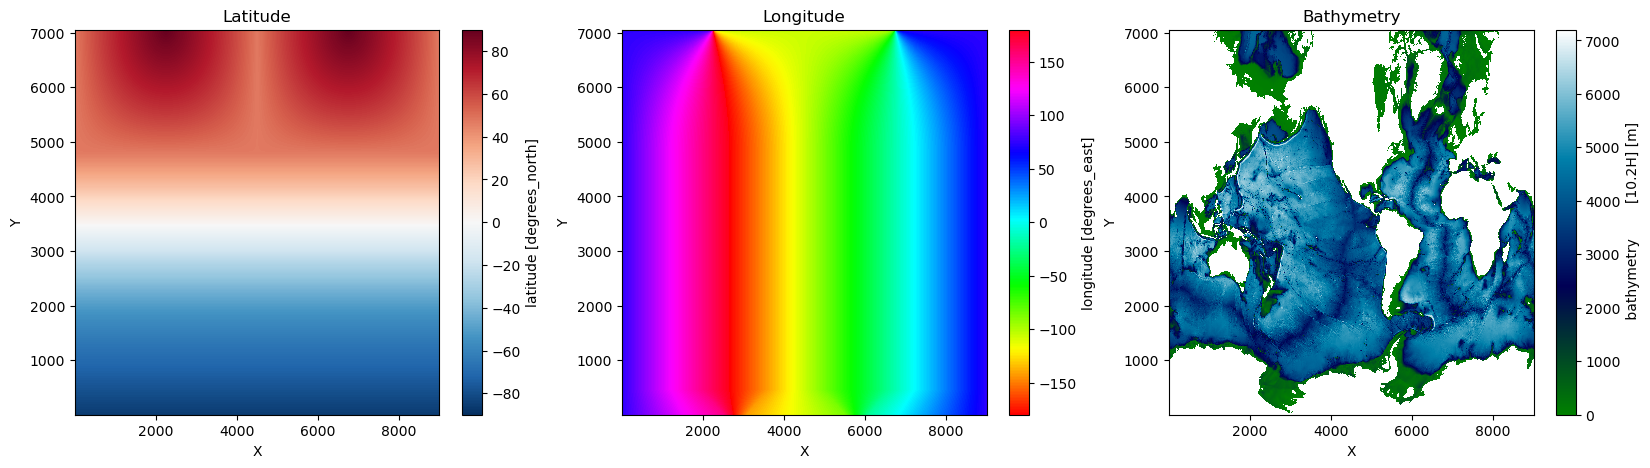

In [6]:
# create a cyclic colormap for longitude
cmap1 = mpl.colormaps["hsv"]
cmap2 = mpl.colormaps["ocean"]
# get the maximum depth in the model
bathymax = ds_bathy["bathymetry"].max().values
print(f"The maximum depth in the domain is {bathymax} m.")

fig, axes = plt.subplots(1, 3, figsize=(20, 5))
# Plot Latitude
ds_bathy['Latitude'].plot(ax=axes[0])
axes[0].set_title('Latitude')
# Plot Longitude
ds_bathy['Longitude'].plot(ax=axes[1], cmap=cmap1)
axes[1].set_title('Longitude')
# Plot Bathymetry
ds_bathy['bathymetry'].plot(ax=axes[2], cmap=cmap2,vmin=0, vmax=np.round(bathymax))
axes[2].set_title('Bathymetry');

## Some simple visualisation of the velocity and SSH data:

Let's examine the structure of the velocity dataset for the chosen step. You can see that the velocity data in the zarr store are chunked as a single chunk along the **time** dimension and the **X** dimension. As such the data are more amenable to analysis along these dimensions.

In [7]:
# display the structure of the velocity dataset
ds_uv

<xarray.Dataset>
Dimensions:    (Depth: 2, Y: 7055, X: 9000, time: 720)
Coordinates:
  * Depth      (Depth) float32 0.0 15.0
    Latitude   (Y, X) float32 dask.array<chunksize=(7055, 9000), meta=np.ndarray>
    Longitude  (Y, X) float32 dask.array<chunksize=(7055, 9000), meta=np.ndarray>
  * X          (X) int32 1 2 3 4 5 6 7 8 ... 8994 8995 8996 8997 8998 8999 9000
  * Y          (Y) int32 1 2 3 4 5 6 7 8 ... 7049 7050 7051 7052 7053 7054 7055
  * time       (time) datetime64[ns] 2014-01-31T01:00:00 ... 2014-03-02
Data variables:
    u          (time, Depth, Y, X) float32 dask.array<chunksize=(720, 1, 1, 9000), meta=np.ndarray>
    v          (time, Depth, Y, X) float32 dask.array<chunksize=(720, 1, 1, 9000), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.0
    experiment:   10.2
    history:      archv2ncdf3z
    source:       HYCOM archive file
    title:        HYCOM

Next, we select the velocity data at a single location (X,Y) of the model, as an example where the model depth is the maximum.

In [8]:
# find the coordinates of the maximum depth and extract the velocity data at that location
max_coords = xr.where(ds_bathy['bathymetry'] == bathymax, True, False).argmax(dim=["X","Y"])
# Get the indices 
X1 = max_coords["X"].values
Y1 = max_coords["Y"].values
print(f"Selecting point at X={X1}, Y={Y1} with latitude {ds_uv['Latitude'].isel(X=X1,Y=Y1).values} and longitude {ds_uv['Longitude'].isel(X=X1,Y=Y1).values} and depth {ds_bathy['bathymetry'].isel(X=X1,Y=Y1).values} m.")

# We can now extract and load the velocity data at this point as a Datarray; and the ssh data as a dataset
z = ds_uv["u"].isel(X=X1-1,Y=Y1)+1j*ds_uv["v"].isel(X=X1-1,Y=Y1).load()
ssh = ds_ssh.isel(X=X1-1,Y=Y1).load()

Selecting point at X=1709, Y=3753 with latitude 11.325518608093262 and longitude 142.52001953125 and depth 7199.98046875 m.


In [9]:
z

<xarray.DataArray (time: 720, Depth: 2)>
dask.array<add, shape=(720, 2), dtype=complex64, chunksize=(720, 1), chunktype=numpy.ndarray>
Coordinates:
  * Depth      (Depth) float32 0.0 15.0
    Latitude   float32 11.33
    Longitude  float32 142.5
    X          int32 1709
    Y          int32 3754
  * time       (time) datetime64[ns] 2014-01-31T01:00:00 ... 2014-03-02

In [10]:
ssh

<xarray.Dataset>
Dimensions:     (time: 720)
Coordinates:
    Latitude    float32 11.33
    Longitude   float32 142.5
    X           int32 1709
    Y           int32 3754
  * time        (time) datetime64[ns] 2014-01-31T01:00:00 ... 2014-03-02
Data variables:
    ssh         (time) float32 0.7643 0.5978 0.4593 0.3917 ... 1.044 1.07 1.01
    steric_ssh  (time) float32 0.6891 0.659 0.63 0.617 ... 0.7339 0.7472 0.7604
Attributes:
    Conventions:  CF-1.0
    experiment:   10.2
    history:      archv2ncdf2d
    source:       HYCOM archive file
    title:        HYCOM

We now visualize the time series of velocity components at the two model depth (0m and 15m), the velocity hodographs, and the SSH time series:

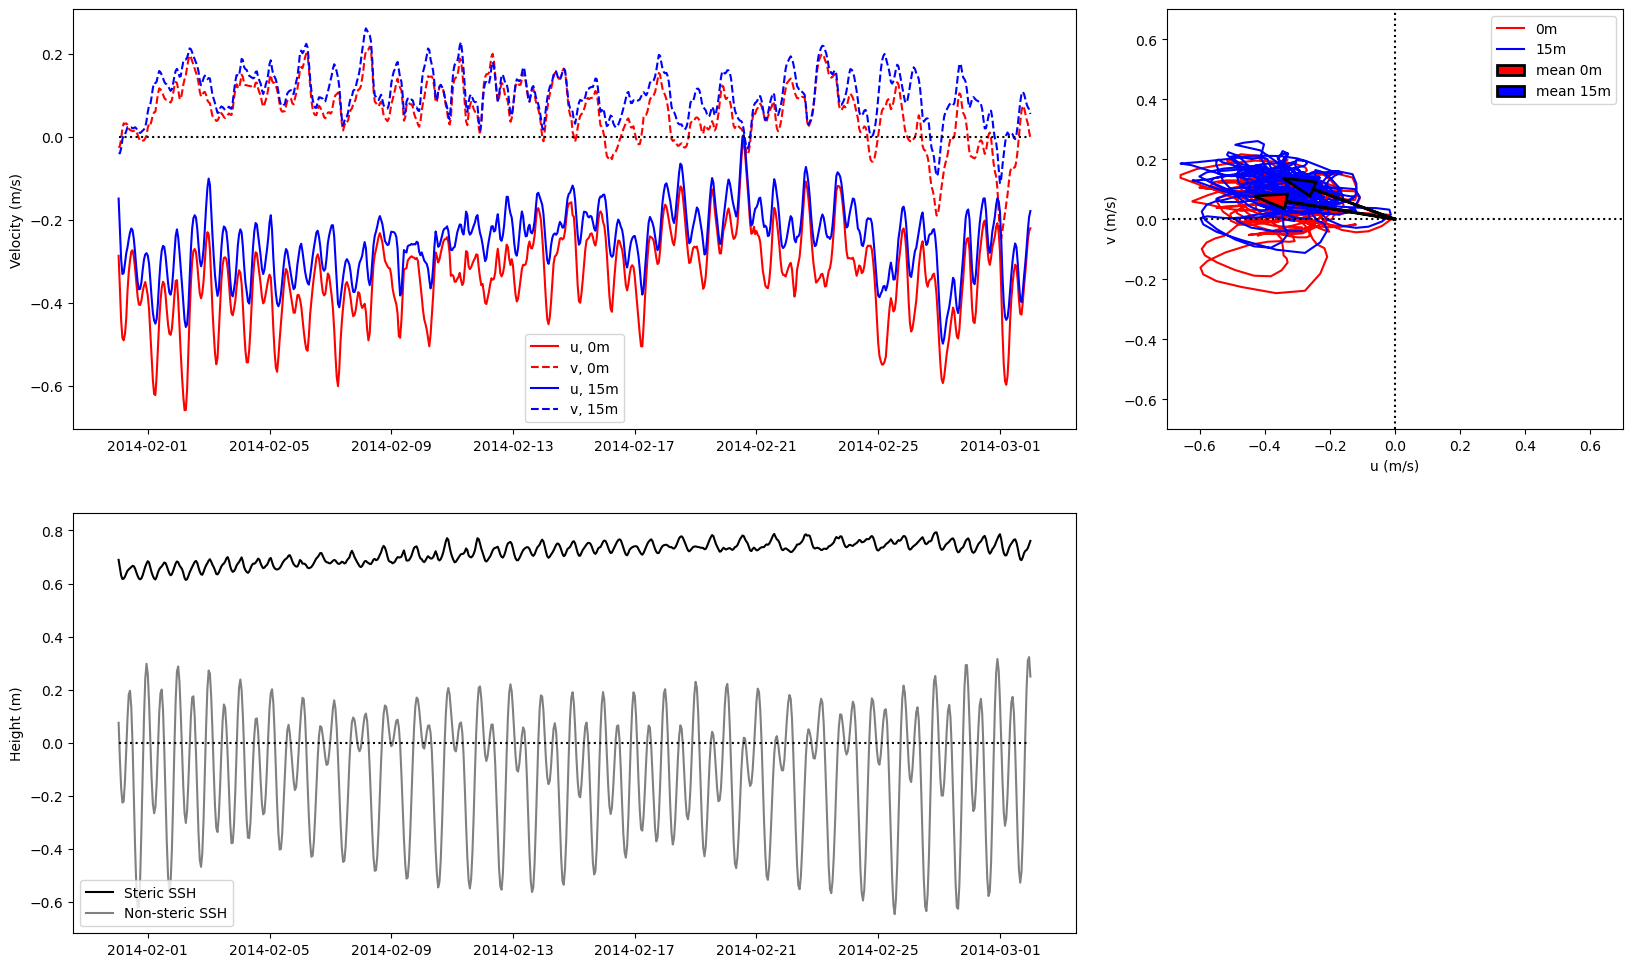

In [11]:
# Create a gridspec instance with 1 row and 3 columns
gs = gridspec.GridSpec(2, 3)

# Create a figure
fig = plt.figure(figsize=(20, 12))

# Create the first subplot of velocity component time series in the first two columns of the grid
ax1 = fig.add_subplot(gs[0, :2])
# velocity time series
ax1.plot(z["time"],z.real.isel(Depth=0),label="u, 0m",color="red",linestyle="-")
ax1.plot(z["time"],z.imag.isel(Depth=0),label="v, 0m",color="red",linestyle="--")
ax1.plot(z["time"],z.real.isel(Depth=1),label="u, 15m",color="blue",linestyle="-")
ax1.plot(z["time"],z.imag.isel(Depth=1),label="v, 15m",color="blue",linestyle="--")
ax1.hlines(0,z["time"][0],z["time"][-1],linestyle=":",color="black")
ax1.set_ylabel("Velocity (m/s)")
ax1.legend()

# Create the second subplot of velocity hodographs in the third column of the grid
ax2 = fig.add_subplot(gs[0, 2])
# velocity hodographs
ax2.plot(z.real.isel(Depth=0),z.imag.isel(Depth=0),color="red",label="0m")
ax2.plot(z.real.isel(Depth=0),z.imag.isel(Depth=1),color="blue",label="15m")
# mean velocity as an arrow
ax2.arrow(0, 0, z.real.isel(Depth=0).mean(), z.imag.isel(Depth=0).mean(), 
    head_width=0.05, head_length=0.1, fc='red', ec='black', linewidth=2, label="mean 0m", zorder=3)
ax2.arrow(0, 0, z.real.isel(Depth=1).mean(), z.imag.isel(Depth=1).mean(), 
    head_width=0.05, head_length=0.1, fc='blue', ec='black', linewidth=2, label="mean 15m", zorder=3)

ax2.set_xlabel("u (m/s)")
ax2.set_ylabel("v (m/s)")
xy_extend = 0.7
ax2.set_xlim(-xy_extend,xy_extend)
ax2.set_ylim(-xy_extend,xy_extend)
ax2.vlines(0,-xy_extend,xy_extend,linestyle=":",color="black")
ax2.hlines(0,-xy_extend,xy_extend,linestyle=":",color="black")
ax2.legend()

ax3 = fig.add_subplot(gs[1, :2])
# SSH time series
ax3.plot(ssh["time"],ssh["steric_ssh"],label="Steric SSH",color="black")
ax3.plot(ssh["time"],ssh["ssh"]-ssh["steric_ssh"],label="Non-steric SSH",color="gray")
ax3.hlines(0,ssh["time"][0],ssh["time"][-1],linestyle=":",color="black")
ax3.set_ylabel("Height (m)")
ax3.legend()

plt.show()

## Some simple spectral analysis:

In this last part of the tutorial, we conduct some simple spectral analysis of the velocity and SSH data. We start by defining a function to calculate a multitaper spectral estimate. We then apply this function to the time series of velocity and SSH to obtain their spectra. If you would like to learn a bit more about estimating spectra with pytho, you can head out to my [dedicated repository](https://github.com/selipot/congenial-spectrum) for that. 

In [12]:
# create a function to get a multitaper spectral estimate
def pmtm(x,dt=1,nw=3,method="unity"):
    """
    spectral multitaper estimate
    Args:
        x : vector input
        dt : sampling rate, default = 1
        nw : time-bandwidth product, default = 3
        k : number of tapers, default 2*nw-1
        method : multitaper method:  eigen, unity (default as it conserve the variance), or adapt
        
    Returns:
        f : Fourier frequencies
        s : spectral estimate
    """
    k = int(2*nw-1)
    f = np.fft.fftfreq(x.shape[0],dt) # define frequency scale/abscissa, dt is in units of days
    psi, eigs = spectrum.mtm.dpss(x.shape[0],NW=nw,k=k)
    if method=="adapt":
        Zk, weights, eigenvalues = spectrum.mtm.pmtm(x-np.mean(x),k,NFFT=np.size(x),v=psi,e=eigs,method=method)
        S = np.mean(np.abs(Zk*weights.T)**2, axis=0)*dt  
    else:
        Zk, weights, eigenvalues = spectrum.mtm.pmtm(x-np.mean(x),k,NFFT=np.size(x),v=psi,e=eigs,method=method)
        S = np.mean(np.abs(Zk*weights)**2, axis=0)*dt  

    return f,S

In [13]:
# Estimate the rotary spectral density of the velocity and SSH time series
dt = 1/24
fz1, Sz1 = pmtm(x=z.isel(Depth=0).to_numpy(),dt=dt)
fz2, Sz2 = pmtm(x=z.isel(Depth=1).to_numpy(),dt=dt)
fz3, Sz3 = pmtm(x=ssh["steric_ssh"].to_numpy(),dt=dt)
fz4, Sz4 = pmtm(x=ssh["ssh"].to_numpy()-ssh["steric_ssh"].to_numpy(),dt=dt)


In [14]:
# Calculate the coriolis frequency in cycles per day which is the opposite of the Coriolis parameter
finert = -86400*(1/(2*np.pi))*coriolis_frequency(ds_uv['Latitude'].isel(X=X1,Y=Y1).values)

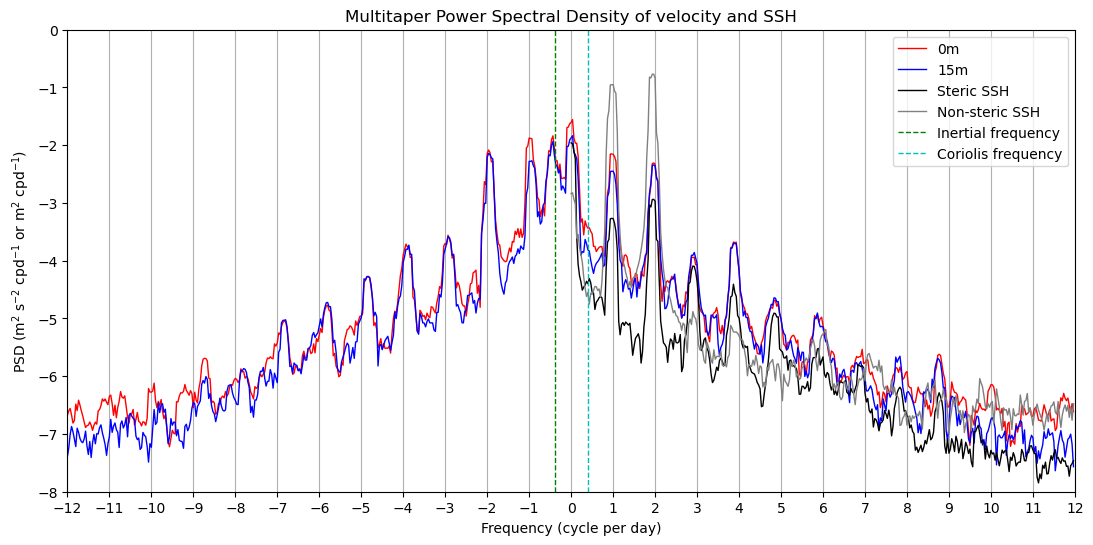

In [15]:
# plot the spectra
# The velocity spectra are rotary spectra, meaning that positive and negative frequencies are meaningful and physically interpretable. 
# For the SSH, only positive frequencies are meaningful and thus we limited the x-axis to positive frequencies but multiply the spectra by two to retain variance.
qpos = np.where(fz3>=0)

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(13, 6))
h1, = ax.plot(np.fft.fftshift(fz1),np.fft.fftshift(np.log10(Sz1)),scaley=True,linewidth=1,color="red",label="0m")
h2, = ax.plot(np.fft.fftshift(fz2),np.fft.fftshift(np.log10(Sz2)),scaley=True,linewidth=1,color="blue",label="15m")
h3, = ax.plot(fz3[qpos],np.log10(2*Sz3[qpos]),scaley=True,linewidth=1,color="black",label="Steric SSH")
h4, = ax.plot(fz4[qpos],np.log10(2*Sz4[qpos]),scaley=True,linewidth=1,color="gray",label="Non-steric SSH")

h5 = ax.vlines(finert,ymin=-8,ymax=0,linewidth=1,color='g',linestyle='--',label='Inertial frequency')
h6 = ax.vlines(-finert,ymin=-8,ymax=0,linewidth=1,color='c',linestyle='--',label='Coriolis frequency')
ax.legend()#,["0m","15m","Steric SSH","Non-steric SSH"])
ax.set_ylabel('PSD (m$^2$ s$^{-2}$ cpd$^{-1}$ or m$^2$ cpd$^{-1}$)')
ax.set_xlabel('Frequency (cycle per day)')
ax.set_xlim([-12,12])
ax.set_xticks(np.arange(-12,12,2))

ax.set_ylim([-8,0])
ax.grid(axis='x')    
ax.title.set_text('Multitaper Power Spectral Density of velocity and SSH')
ax.set_xticks(ticks=np.arange(-12,13,1));

As you can see in the figure above, both the velocity and SSH signals exhibit large tidal peaks near 1,2,3 etc cycles per day. At the inertial and Coriolis frequencies, only the velocity signals seem to exhibit a significant peak.